# This investigates the theory proposed in Singh 2013

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, R
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate

2023-02-14 16:09:15,913 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset for each kappa value
var_keep = ['temp', 'sphum', 'height', 'cape', 'cin']        # only keep variables required to compute relative humidity and MSE
exp_dir = 'tau_sweep/land/meridional_band/bucket/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds += [ds_use[var_keep]]    # only keep required variables
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]


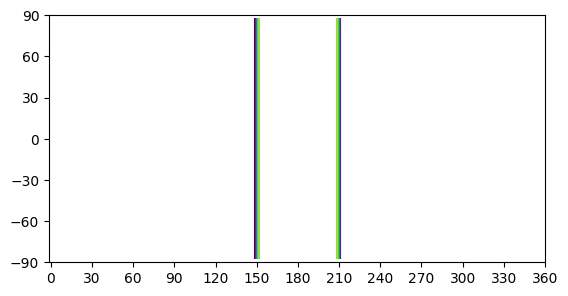

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get datasets for the summer mean over ocean in the tropics

In [4]:
use_time_start = 360*2
# Tropics
lat_min = 0
lat_max = 20
# Extratropics
# lat_min = 30
# lat_max = 60

surf_use = 'land'

ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(lon=np.unique(lon[surf_use]), method='nearest')
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_summer += [ds_use.mean(dim='lon_lat_time')]      # take mean value
        ds_summer[i].load()
        pbar.update(1)

100%|██████████| 6/6 [00:36<00:00,  6.10s/it]


## Singh 2013 - Figure 1a

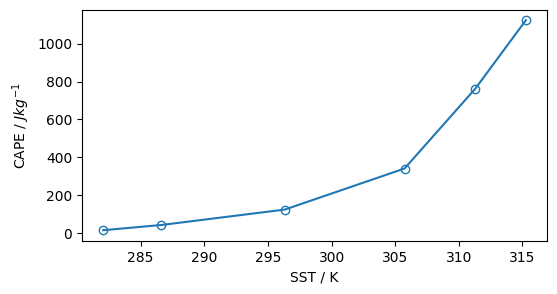

In [5]:
# Plot CAPE vs SST for mean summer day over ocean as in figure 1 of Singh 2013
cape = [float(ds_summer[i].cape) for i in range(n_exp)]
sst = [float(ds_summer[i].temp[-1]) for i in range(n_exp)]
fig, ax = plt.subplots(1,1, figsize=(6, 3))
ax.plot(sst, cape, marker='o', fillstyle='none')
ax.set_xlabel('SST / K')
ax.set_ylabel('CAPE / $Jkg^{-1}$');

## Singh 2013 - Figure 2a
This uses actual temperature instead of virtual temperature though.

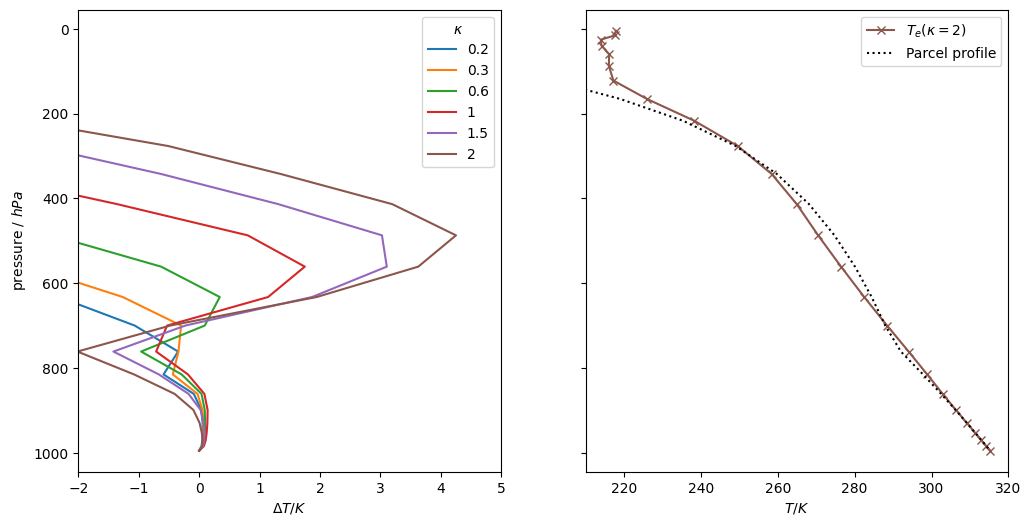

In [6]:
profile_plot_ind = 5
p_surface = float(ds_summer[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

parcel_temp_profile = [convection_neutral_profile(float(ds_summer[i].temp[-1]), p_surface,
                                                  float(ds_summer[i].sphum[-1]),
                                                  ds_summer[i].temp.pfull.to_numpy()*100) for i in range(n_exp)]
delta_temp = [parcel_temp_profile[i]-ds_summer[i].temp for i in range(n_exp)]

fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
for i in range(n_exp):
    ax[0].plot(delta_temp[i], delta_temp[i].pfull, label=tau_lw[i])
ax[0].invert_yaxis()
ax[0].legend(title='$\kappa$')
ax[0].set_xlim([-2, 5])
ax[0].set_xlabel('$\Delta T / K$')
ax[0].set_ylabel('pressure / $hPa$')
ax[1].plot(ds_summer[profile_plot_ind].temp, ds_summer[profile_plot_ind].pfull, marker='x',
           color=plt.rcParams['axes.prop_cycle'].by_key()['color'][profile_plot_ind], label=f'$T_e(\kappa={tau_lw[profile_plot_ind]})$')
ax[1].plot(parcel_temp_profile[profile_plot_ind], ds_summer[profile_plot_ind].pfull, linestyle=':', color='k', label='Parcel profile')
ax[1].legend()
ax[1].set_xlim(210,320)
ax[1].set_xlabel('$T/K$');

In [7]:
# Functions to work out the model value of Delta T

def sphum_sat(temp, pressure):
    # Requires input pressure in units of Pa
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def lcl_pressure(dataset):
    # Return pressure in hPa
    temp_lcl = lcl_temp(dataset.temp[-1], dataset.pfull[-1]*100, dataset.sphum[-1])
    p_lcl = dataset.pfull[-1] * (temp_lcl/dataset.temp[-1])**(1/kappa)      # Pressure corresponding to LCL from dry adiabat equation
    return p_lcl

def delta_temp_theory(dataset, epsilon_hat=0.75, rh=0.8):
    """
    Returns model value of Delta T at each height/pressure value in dataset.
    First value refers to surface value and is 0.

    Args:
        dataset:
        epsilon_hat:
        rh:

    Returns:

    """
    # Formula is only valid above the lifting condensation level or cloud base so first find that and get rid of p values below it
    p_lcl = lcl_pressure(dataset)
    # Ensure include LCL pressure in the plot by finding nearest pressure value in dataset that is near it
    near_ind = np.argmin(np.abs(dataset.pfull.to_numpy() - p_lcl.to_numpy()))
    if dataset.pfull[near_ind] < p_lcl:
        # Ensure pressure level found is above the LCL
        near_ind += 1
    p_lcl = float(dataset.pfull[near_ind])
    small = 1       # small shift to p_lcl so ensure that pressure level included
    dataset = dataset.sel(pfull=slice(0, p_lcl+small))
    # [::-1] so first value is at surface
    q_sat = np.asarray(sphum_sat(dataset.temp, dataset.pfull * 100))[::-1]
    temp = np.asarray(dataset.temp)[::-1]
    integrand = L_v/c_p * q_sat
    height = np.asarray(dataset.height)[::-1]
    integral = np.asarray([integrate.simpson(integrand[:i], height[:i]) for i in range(1, height.size+1)])
    denom = 1 + L_v **2 * q_sat / (c_p * R_v * temp**2)
    epsilon = epsilon_hat / height      # use form of epsilon suggested in paper
    return epsilon * (1-rh) / denom * integral, dataset.pfull[::-1]


The plot below adds the model estimate of $\Delta T$ (equation 4 in the paper) to the left plot above.

It appears that the theoretical estimate (grey, dotted) does a good job at matching the simulated profile (black, solid) up until the turning point (i.e. maximum value of $\Delta T$) if we use the same values of $\hat{\epsilon} = 0.75$ and relative humidity of 0.8 as used in the paper.

This matches the findings of the paper if we take the turning point to be the anvil detrainment level.

The plots clearly show that both the maximum value of $\Delta T$ increases and the Level of Neutral Buoyancy (LNB, smallest pressure value where $\Delta T$ crosses 0) decreases with $\kappa$.

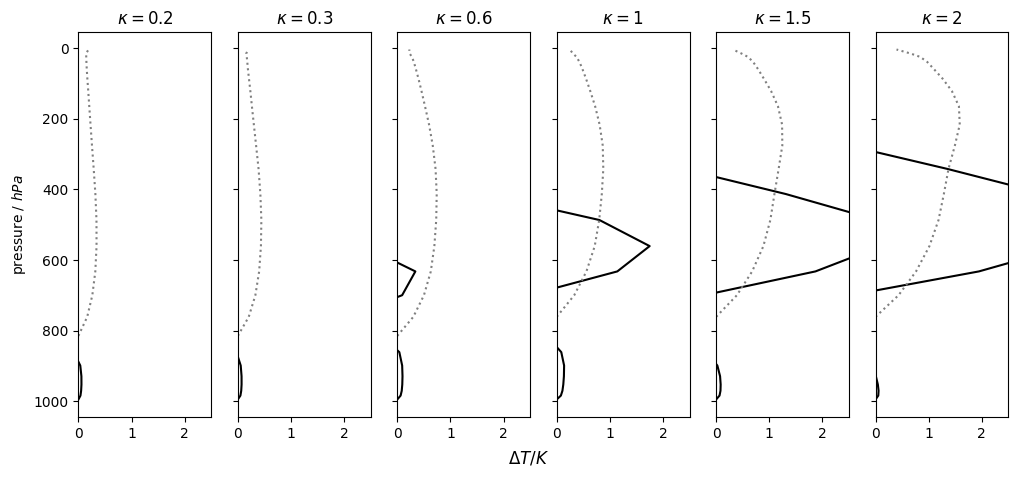

In [21]:
fig, ax = plt.subplots(1,6, figsize=(12, 5), sharey=True, sharex=True)
epsilon_hat = 0.75
rh_constant = 0.8
for i in range(n_exp):
    a, b = delta_temp_theory(ds_summer[i], epsilon_hat, rh_constant)
    ax[i].plot(delta_temp[i], delta_temp[i].pfull, color='k')
    ax[i].plot(a, b, linestyle=':', color='grey')
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[0].invert_yaxis()
ax[0].set_xlim([0,2.5])
fig.supxlabel('$\Delta T / K$')
ax[0].set_ylabel('pressure / $hPa$');

In [9]:
# Functions for computing CAPE from the

def get_cape_manual(delta_temp, p_levels):
    # delta_temp is temp_parcel - temp_environment
    # p_levels need to be in units of Pa and should be descending
    # They are all pressure levels between the LFC and the LNB
    # p_levels[0] is the LFC and p_levels[-1] is the LNB.
    integrand = -R * delta_temp / p_levels
    return integrate.simpson(integrand, p_levels)

def get_cape_integ_values(delta_temp, p_levels):
    # Assume p_levels are ascending
    # Want pressure levels in between lowest 2 pressure levels where delta_temp changes sign
    # Returned p_levels will have p_levels[0] as LNB and p_levels[-1] ans LFC.
    sign_change_ind = np.where(np.diff(np.sign(delta_temp)) != 0)[0]
    lnb_ind = sign_change_ind[0]        # delta_temp is negative at lnb_ind
    lfc_ind = sign_change_ind[1] + 1    # delta_temp is negative at lnb_ind
    use_ind = np.arange(lnb_ind, lfc_ind+1)
    return delta_temp[use_ind], p_levels[use_ind]

def get_anvil_detrainment_level(delta_temp, p_levels):
    # Assume anvil detrainment level is pressure corresponding to maxima in delta_temp
    return p_levels[np.argmax(delta_temp)]

In [15]:
# Compute CAPE by integrating either simulated or modelled Delta T in correct pressure level range
lfc = np.zeros(n_exp)
lnb = np.zeros(n_exp)
cape_manual = np.zeros(n_exp)
cape_model = np.zeros(n_exp)
adl = np.zeros(n_exp)
cape_manual_adl = np.zeros(n_exp)
cape_model_adl = np.zeros(n_exp)
for i in range(n_exp):
    # Method using LNB as the upper limit to integration
    delta_temp_use, p_levels_use = get_cape_integ_values(delta_temp[i], delta_temp[i].pfull)
    lfc[i] = p_levels_use.max()
    lnb[i] = p_levels_use.min()
    cape_manual[i] = get_cape_manual(delta_temp_use[::-1], p_levels_use[::-1] * 100)
    delta_temp_use_model, p_levels_use_model = delta_temp_theory(ds_summer[i], epsilon_hat)
    model_ind = np.where(p_levels_use_model >= lnb[i])
    # Method using ADL as the upper limit to integration
    adl[i] = get_anvil_detrainment_level(delta_temp[i].to_numpy(), delta_temp[i].pfull)
    adl_manual_ind = np.where(p_levels_use >= adl[i])
    cape_manual_adl[i] = get_cape_manual(delta_temp_use[adl_manual_ind][::-1], p_levels_use[adl_manual_ind][::-1] * 100)
    adl_model_ind = np.where(p_levels_use_model >= adl[i])
    try:
        cape_model[i] = get_cape_manual(delta_temp_use_model[model_ind], p_levels_use_model[model_ind] * 100)
    except IndexError:
        cape_model[i] = 0
    try:
        cape_model_adl[i] = get_cape_manual(delta_temp_use_model[adl_model_ind], p_levels_use_model[adl_model_ind] * 100)
    except IndexError:
        cape_model_adl[i] = 0

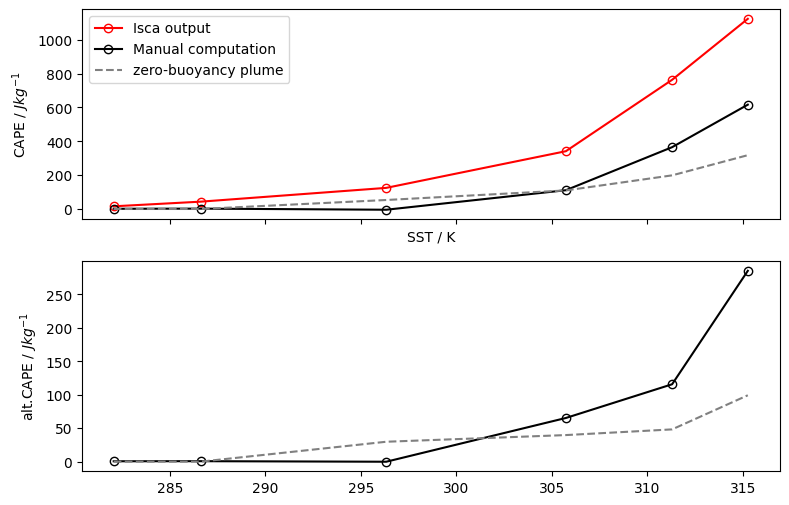

In [16]:
fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
ax[0].plot(sst, cape, marker='o', fillstyle='none', label='Isca output', color='r')
ax[0].plot(sst, cape_manual, marker='o', fillstyle='none', label='Manual computation', color='k')
ax[0].plot(sst, cape_model, linestyle='--', color='grey', label='zero-buoyancy plume')
ax[1].plot(sst, cape_manual_adl, marker='o', fillstyle='none', label='Manual computation', color='k')
ax[1].plot(sst, cape_model_adl, linestyle='--', color='grey', label='zero-buoyancy plume')
ax[0].set_xlabel('SST / K')
ax[0].set_ylabel('CAPE / $Jkg^{-1}$')
ax[1].set_ylabel('alt.CAPE / $Jkg^{-1}$')
ax[0].legend();

The plot above replicates Figure 1 of Singh 2013, including the model outputs. The model does pretty well at predicting the CAPE output by the Isca model.

It is also a very close match to the manual computed CAPE if the upper bound is taken to be the anvil detrainment level, rather than the level of neutral buoyancy.

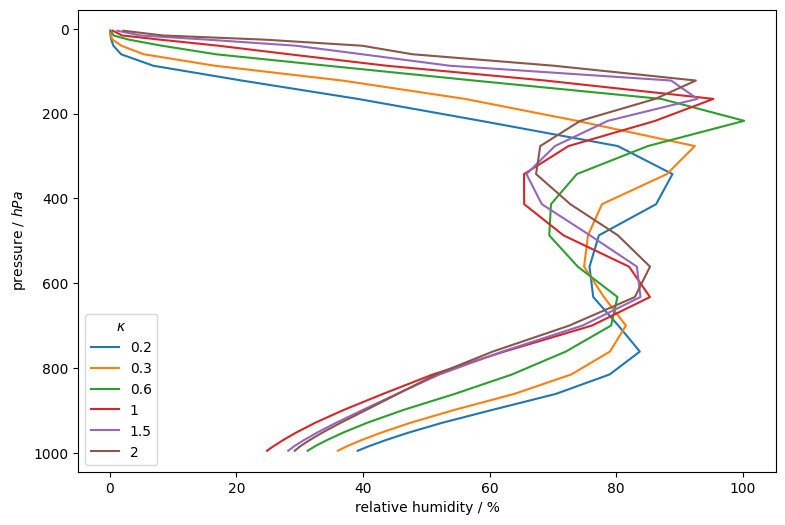

In [17]:
rh = [rh_from_sphum(ds_summer[i].sphum, ds_summer[i].temp, ds_summer[i].pfull * 100) for i in range(n_exp)]
fig, ax = plt.subplots(1,1, figsize=(9, 6))
for i in range(n_exp):
    ax.plot(rh[i], ds_summer[i].pfull, label=f'{tau_lw[i]}')
ax.invert_yaxis()
ax.set_ylabel('pressure / $hPa$')
ax.set_xlabel('relative humidity / %')
ax.legend(title='$\kappa$');

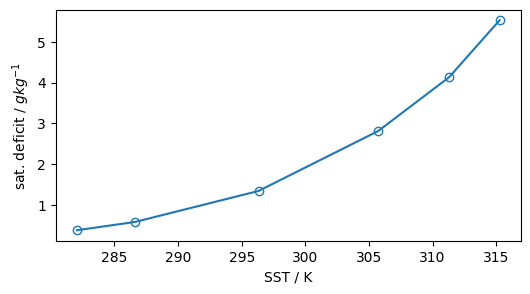

In [18]:
def sphum_deficit(dataset):
    return float(np.mean(sphum_sat(dataset.temp, dataset.pfull * 100) - dataset.sphum))
sat_deficit = np.asarray([sphum_deficit(ds_summer[i].sel(pfull=slice(500, 850))) for i in range(n_exp)])
fig, ax = plt.subplots(1,1, figsize=(6, 3))
ax.plot(sst, sat_deficit * 1000, marker='o', fillstyle='none')
ax.set_xlabel('SST / K')
ax.set_ylabel('sat. deficit / $g kg^{-1}$');

## Using actual RH
The plots below show that when the actual relative humidity profile is used, there is not much difference to the constant RH=0.8 model.

In [20]:
def delta_temp_theory_with_rh(dataset, epsilon_hat=0.75):
    """
    Returns model value of Delta T at each height/pressure value in dataset.
    First value refers to surface value and is 0.

    This does not assume that relative humidity is constant in the free troposphere, but uses the actual values
    based on the specific humidity and temperature.

    Args:
        dataset:
        epsilon_hat:

    Returns:

    """
    # Formula is only valid above the lifting condensation level or cloud base so first find that and get rid of p values below it
    p_lcl = lcl_pressure(dataset)
    # Ensure include LCL pressure in the plot by finding nearest pressure value in dataset that is near it
    near_ind = np.argmin(np.abs(dataset.pfull.to_numpy() - p_lcl.to_numpy()))
    if dataset.pfull[near_ind] < p_lcl:
        # Ensure pressure level found is above the LCL
        near_ind += 1
    p_lcl = float(dataset.pfull[near_ind])
    small = 1       # small shift to p_lcl so ensure that pressure level included
    dataset = dataset.sel(pfull=slice(0, p_lcl+small))
    # [::-1] so first value is at surface
    q_sat = np.asarray(sphum_sat(dataset.temp, dataset.pfull * 100))[::-1]
    rh = dataset.sphum[::-1] / q_sat
    temp = np.asarray(dataset.temp)[::-1]
    integrand = L_v/c_p * q_sat * (1-rh)
    height = np.asarray(dataset.height)[::-1]
    integral = np.asarray([integrate.simpson(integrand[:i], height[:i]) for i in range(1, height.size+1)])
    denom = 1 + L_v **2 * q_sat / (c_p * R_v * temp**2)
    epsilon = epsilon_hat / height      # use form of epsilon suggested in paper
    return epsilon / denom * integral, dataset.pfull[::-1]

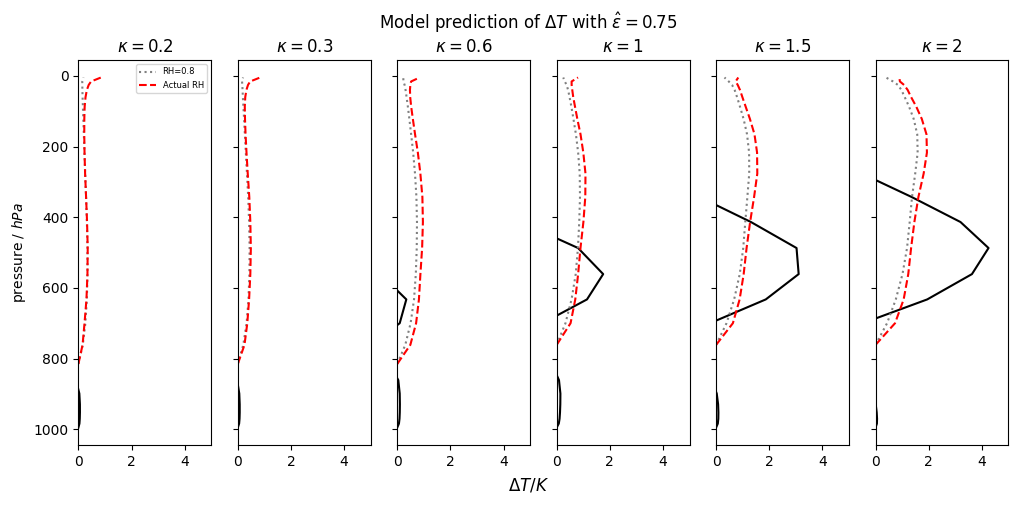

In [22]:
fig, ax = plt.subplots(1,6, figsize=(12, 5), sharey=True, sharex=True)
for i in range(n_exp):
    a, b = delta_temp_theory(ds_summer[i], epsilon_hat)
    a2, b2 = delta_temp_theory_with_rh(ds_summer[i], epsilon_hat)
    ax[i].plot(delta_temp[i], delta_temp[i].pfull, color='k')
    ax[i].plot(a, b, linestyle=':', color='grey', label=f'RH={rh_constant}')
    ax[i].plot(a2, b2, linestyle='--', color='r', label=f'Actual RH')
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[0].invert_yaxis()
ax[0].set_xlim([0,5])
fig.supxlabel('$\Delta T / K$')
ax[0].set_ylabel('pressure / $hPa$')
ax[0].legend(fontsize=6)
fig.suptitle('Model prediction of $\Delta T$ with $\hat{\epsilon}='+f'{epsilon_hat}$');

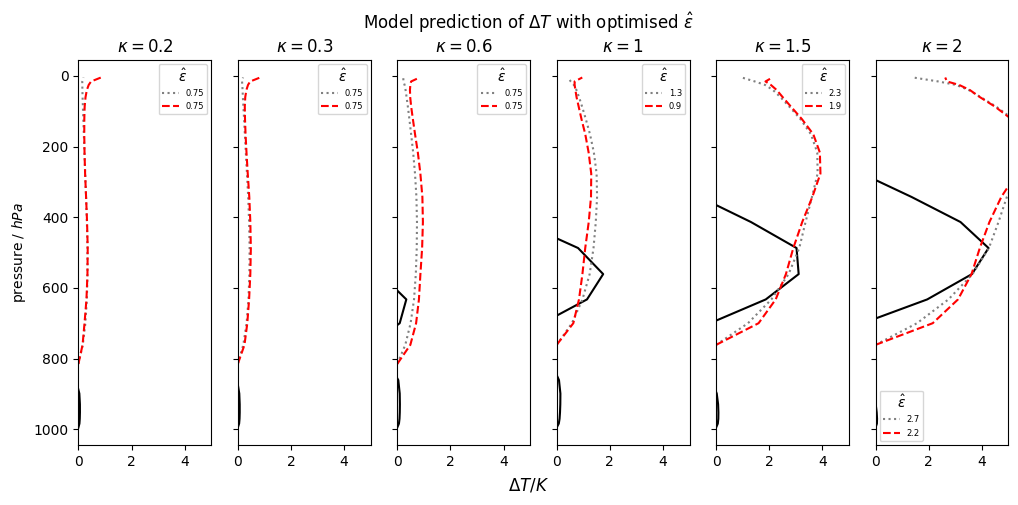

In [33]:
epsilon_list = [0.75, 0.75, 0.75, 1.3, 2.3, 2.7]
epsilon_list2 = [0.75, 0.75, 0.75, 0.9, 1.9, 2.2]
fig, ax = plt.subplots(1,6, figsize=(12, 5), sharey=True, sharex=True)
for i in range(n_exp):
    a, b = delta_temp_theory(ds_summer[i], epsilon_list[i])
    a2, b2 = delta_temp_theory_with_rh(ds_summer[i], epsilon_list2[i])
    ax[i].plot(delta_temp[i], delta_temp[i].pfull, color='k')
    ax[i].plot(a, b, linestyle=':', color='grey', label=f'{epsilon_list[i]}')
    ax[i].plot(a2, b2, linestyle='--', color='r', label=f'{epsilon_list2[i]}')
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
    ax[i].legend(title='$\hat{\epsilon}$', fontsize=6)
ax[0].invert_yaxis()
ax[0].set_xlim([0,5])
fig.supxlabel('$\Delta T / K$')
ax[0].set_ylabel('pressure / $hPa$')
fig.suptitle('Model prediction of $\Delta T$ with optimised $\hat{\epsilon}$');

The plot above shows that if we allow $\hat{\epsilon}$ to vary, then whether we use the actual relative humidity or not, doesn't seem to make much difference. This makes sense because the actual relative humidity profiles do show an approximately constant value in the free troposphere and varying $\hat{\epsilon}$ is equivalent to changing the value of this constant relative humidity.

So below if we use the constant 0.8 relative humidity model with varying $\hat{\epsilon}$, we do pretty will at matching the simulated CAPE.

In [35]:
# Compute CAPE while allowing different epsilon for each quantile
cape_model2 = np.zeros(n_exp)
cape_model2_adl = np.zeros(n_exp)
for i in range(n_exp):
    # Method using LNB as the upper limit to integration
    delta_temp_use_model, p_levels_use_model = delta_temp_theory(ds_summer[i], epsilon_list[i])
    model_ind = np.where(p_levels_use_model >= lnb[i])
    try:
        cape_model2[i] = get_cape_manual(delta_temp_use_model[model_ind], p_levels_use_model[model_ind] * 100)
    except IndexError:
        cape_model2[i] = 0

    # Method using ADL as the upper limit to integration
    adl_model_ind = np.where(p_levels_use_model >= adl[i])
    try:
        cape_model2_adl[i] = get_cape_manual(delta_temp_use_model[adl_model_ind], p_levels_use_model[adl_model_ind] * 100)
    except IndexError:
        cape_model2_adl[i] = 0

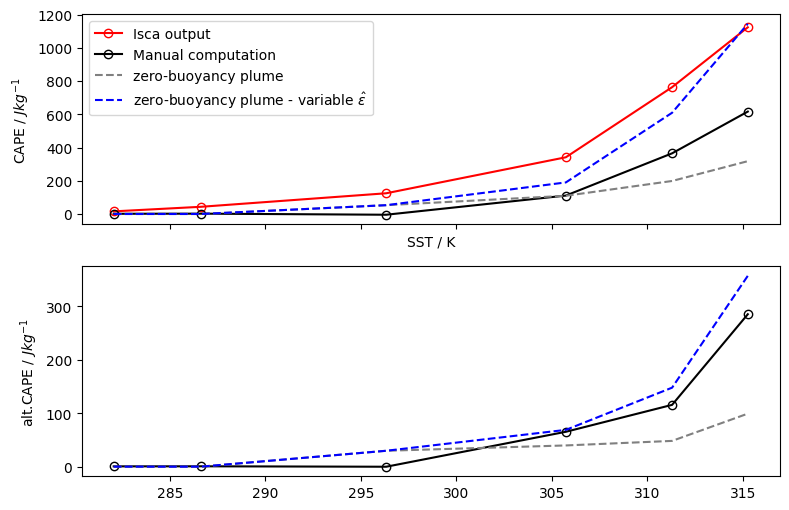

In [36]:
fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
ax[0].plot(sst, cape, marker='o', fillstyle='none', label='Isca output', color='r')
ax[0].plot(sst, cape_manual, marker='o', fillstyle='none', label='Manual computation', color='k')
ax[0].plot(sst, cape_model, linestyle='--', color='grey', label='zero-buoyancy plume')
ax[0].plot(sst, cape_model2, linestyle='--', color='blue', label='zero-buoyancy plume - variable $\hat{\epsilon}}$')
ax[1].plot(sst, cape_manual_adl, marker='o', fillstyle='none', label='Manual computation', color='k')
ax[1].plot(sst, cape_model_adl, linestyle='--', color='grey', label='zero-buoyancy plume')
ax[1].plot(sst, cape_model2_adl, linestyle='--', color='blue', label='zero-buoyancy plume')
ax[0].set_xlabel('SST / K')
ax[0].set_ylabel('CAPE / $Jkg^{-1}$')
ax[1].set_ylabel('alt.CAPE / $Jkg^{-1}$')
ax[0].legend();